In [78]:
!pip3 install gymnasium[classic_control]

# Environment Setup

Goal: Use DQN model to setup optimal temperature for a room <br>

Factors affecting initial temperature: <br>
<ol>
    <li> Room booking status </li>
    <li> Outside Temp</li>
    <li> Day </li>
    <li> Time </li>
</ol>

Action taken by DQN: <br>
<ol>
    <li> Increase Temperature </li>
    <li> Decrease Temperature   </li>
    <li> Maintain Temperature </li>
</ol>

Rewards for DQN : <br>
<ol>
    <li> Energy Consumption Levels</li>
    <li> User Comfort</li>

In [79]:
import gym # OpenAI env
import math
import random
import matplotlib # Plot
import matplotlib.pyplot as plt
from collections import namedtuple, deque # Python build-in data structure
from itertools import count

In [80]:
# Neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [81]:
headers = ['day_','time_','outside_temp','inside_temp','booking_status',"energy_consumption","change_in_temp"]
total_data=1008
scale=1

#generate DAY (first column of data)
day_ = []
day_in_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(6*scale):
    for day in day_in_week:
        for j in range(24):
            day_.append(day)

#generate TIME (second column of data)
time_ = []
for i in range(6*7*scale):
    for j in range(24):
        if j%2==1:
            time_.append(int(j/2)*100+830)
        else:
            time_.append(int(j/2)*100+800)

import numpy as np
#generate OUTSIDE_TEMP (third column of data)
outside_temp = []
mean = 30
std_dev = 1
day_temp = np.random.normal(mean, std_dev, size=42*scale)
day_temp = np.round(day_temp, decimals=1)
for day_mean in day_temp:
    for i in range(24):
        hour_temp = np.random.normal(day_mean, 0.5)
        hour_temp = np.round(hour_temp, decimals=1)
        outside_temp.append(hour_temp)
print(outside_temp)

#generate INSIDE_TEMP (fourth column of data)
inside_temp = []
mean = 22
std_dev = 2
inside_day_temp = np.random.normal(mean, std_dev, size=42*scale)
inside_day_temp = np.round(inside_day_temp, decimals=1)
for inside_day_mean in inside_day_temp:
    for i in range(24):
        inside_hour_temp = np.random.normal(inside_day_mean, 1)
        inside_hour_temp = np.round(inside_hour_temp, decimals=1)
        inside_temp.append(inside_hour_temp)
print(inside_temp)

#generate BOOKING_STATUS (fifth column of data)
booking_status = []
bernoulli_values = np.random.binomial(n=1, p=0.7, size=24*7)
for i in range(6*scale):
    for j in range(24*7):
        booking_status.append(bernoulli_values[j])
print(booking_status)

#generate ENERGY_CONSUMPTION (sixth column of data)
energy_consumption = []
optimal_consumption = 3000
for i in range(1008*scale):
    hourly_consumption = 3000 + abs(inside_temp[i]-25)*125 + np.random.normal(100, 20)
    energy_consumption.append(hourly_consumption)

#generate CHANGE_IN_TEMP (seventh column of data)
change_in_temp = []
for i in range(1008*scale):
    if(booking_status[i] == 0):
        change_in_temp.append(0)
    elif(booking_status[i] == 1):
        if(outside_temp[i] < 25): #cold weather
            if (inside_temp[i] < 20):
                change_in_temp.append(np.random.randint(0, 6))
            elif (inside_temp[i] < 23):
                change_in_temp.append(np.random.randint(0,3))
            else:
                change_in_temp.append(np.random.randint(-2, 1))
        else: #hot weather
            if (inside_temp[i] < 20):
                change_in_temp.append(np.random.randint(0, 2))
            elif (inside_temp[i] < 23):
                change_in_temp.append(np.random.randint(-2, 3))
            else:
                change_in_temp.append(np.random.randint(-5, 3))


[28.5, 29.9, 28.5, 29.3, 29.8, 27.8, 26.9, 29.0, 28.3, 27.6, 28.6, 28.5, 28.3, 28.0, 28.6, 28.0, 27.5, 29.0, 28.7, 29.1, 29.3, 28.2, 28.7, 28.0, 30.5, 30.8, 31.2, 30.4, 30.2, 31.0, 30.9, 31.1, 30.2, 31.0, 31.1, 29.9, 31.0, 30.8, 30.1, 30.3, 31.0, 30.9, 31.1, 30.5, 30.6, 30.6, 31.8, 30.9, 31.3, 32.3, 31.2, 32.2, 31.6, 32.6, 31.8, 32.1, 32.0, 31.2, 31.8, 31.6, 31.1, 31.9, 31.7, 31.4, 32.7, 31.8, 32.1, 32.2, 31.7, 32.0, 32.7, 31.6, 30.2, 30.6, 29.7, 29.8, 31.2, 30.3, 30.0, 30.1, 30.2, 29.8, 30.8, 30.9, 29.4, 30.3, 29.4, 30.0, 30.6, 29.2, 30.3, 30.8, 29.6, 29.7, 29.9, 29.4, 29.1, 29.1, 28.2, 28.6, 29.0, 28.2, 28.9, 28.8, 29.0, 27.7, 29.2, 28.2, 28.6, 28.7, 27.8, 28.4, 28.7, 28.3, 28.5, 28.8, 28.2, 27.8, 28.0, 29.2, 30.7, 30.1, 29.4, 30.3, 31.1, 30.3, 30.8, 31.0, 29.7, 29.9, 30.9, 30.2, 31.2, 30.2, 30.3, 30.0, 29.7, 30.2, 30.0, 30.8, 30.6, 30.0, 30.1, 29.2, 30.9, 30.8, 30.4, 29.2, 30.1, 30.4, 30.5, 29.9, 30.2, 30.9, 30.5, 30.3, 30.8, 30.2, 30.6, 30.2, 30.9, 29.5, 30.8, 30.4, 30.5, 31.1, 29.

In [82]:
from openpyxl import Workbook

# Create a new workbook
workbook = Workbook()

# Access the active sheet
sheet = workbook.active

sheet.append(headers)

for i in range(1008*scale):
    sheet.append([day_[i], time_[i], outside_temp[i], inside_temp[i], booking_status[i], energy_consumption[i], change_in_temp[i]])

# Save the workbook
workbook.save('output.xlsx')

In [83]:
# Machine Learning to predict energy consumption

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
training_data = pd.read_excel('output.xlsx')
# for day data change mon to 1, tue to 2 etc

training_data['day_'] = training_data['day_'].replace(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],[1,2,3,4,5,6,7])
features = ['day_', 'time_', 'outside_temp', 'inside_temp', 'booking_status']
X = training_data[features]
y = training_data['energy_consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Random forest model to predict energy consumption

rf_model = RandomForestRegressor(n_estimators=200, random_state= 50) # 200 trees, random_state for reproducibility
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# percentage error
percentage_error = (np.mean(np.abs((y_test - y_pred) / y_test)) * 100)
print(f"Percentage Error: {percentage_error}")

Mean Squared Error: 485.6233442176281
Percentage Error: 0.4983105505672758


In [84]:
# Equation to calculate energy consumption
def energy_consumption(day, time, outside_temp, inside_temp, booking_status):
    day = day
    time = time
    outside_temp = outside_temp
    inside_temp = inside_temp
    booking_status = booking_status
    energy_consumption = rf_model.predict([[day, time, outside_temp, inside_temp, booking_status]])
    return energy_consumption

def user_comfort(outside_temp, inside_temp, booking_status):
    if(booking_status == 0):
        change_in_temp = 0
    elif(booking_status == 1):
        if(outside_temp < 25): #cold weather
            if (inside_temp < 20):
                change_in_temp = np.random.randint(0, 6)
            elif (inside_temp < 23):
                change_in_temp = np.random.randint(0,3)
            else:
                change_in_temp = np.random.randint(-2, 1)
        else: #hot weather
            if (inside_temp < 20):
                change_in_temp = np.random.randint(0, 2)
            elif (inside_temp < 23):
                change_in_temp = np.random.randint(-2, 3)
            else:
                change_in_temp = np.random.randint(-5, 3)
    new_temp = inside_temp + change_in_temp
    return new_temp
            


In [85]:
import gym
import numpy as np
from gym import spaces
import random

class ThermostatEnvironment(gym.Env):
    def __init__(self):
        super(ThermostatEnvironment, self).__init__()
        self.day = 1
        self.time = 1
        self.booking_status = 0
        self.machine_temp = 18
        self.outside_temp = random.randint(23, 40)
        self.actual_temp = user_comfort(self.outside_temp, self.machine_temp, self.booking_status)
        self.action_space = spaces.Discrete(3)  # Increase, Decrease, Maintain
        self.observation_space = spaces.Box(low=np.array([1, 1, 0, 23, 18]), high=np.array([5, 24, 1, 40, 25]), dtype=np.float32)
        self.max_temp = 25
        self.min_temp = 18
        self.reward = 0
        self.done = False
    
    
    def update_environment(self, time, day):
            if time == 24:
                time = 1
                if day == 7:
                    day = 8
                else:
                    day += 1
            else:
                time += 1
            return time, day, random.randint(0, 1), random.randint(23, 40)

    def step(self, action):
        
        # Action logic
        if action == 0: # Increase temperature
            self.machine_temp += 1
        elif action == 2: # Decrease temperature
            self.machine_temp -= 1
        else: # Maintain temperature
            pass

        

        # Ensure temperature is within bounds
        self.machine_temp = np.clip(self.machine_temp, self.min_temp, self.max_temp)

        # Calculate energy consumption
        energy = energy_consumption(self.day, self.time, self.outside_temp, self.machine_temp, self.booking_status)

        # Calculate reward
        # Adjust the energy_reward calculation
        energy_reward = -((energy - 3000) / 3000)**2  # Quadratic penalty for deviation

        # Introduce a threshold for acceptable energy consumption
        acceptable_energy_threshold = 3200
        if energy <= acceptable_energy_threshold:
            energy_reward += 0.2
        #print(f"Energy Reward: {energy_reward}")

        # Modify the comfort_reward calculation
        temperature_range_penalty = 0.1  # Adjust based on your criteria
        comfort_reward = temperature_range_penalty * (self.actual_temp - self.machine_temp)**2

        #print(f"Comfort Reward: {comfort_reward}")

        # Adjust the weights and introduce a trade-off factor
        trade_off_factor = 0.4  # Adjust based on your desired trade-off
        reward = (1 - trade_off_factor) * energy_reward + trade_off_factor * comfort_reward
        #print(f"Total Reward: {reward}")

        self.reward += reward
        self.time, self.day, self.booking_status, self.outside_temp = self.update_environment(self.time, self.day)
        if self.day == 8:
            self.done = True

        return np.array([self.day, self.time, self.booking_status, self.outside_temp, self.actual_temp]), reward, self.done, {}

    
    def reset(self):
        self.day = 1
        self.time = 1
        self.booking_status = 1
        self.outside_temp = 30
        self.machine_temp = 18 # temp set by machine
        self.actual_temp = user_comfort(self.outside_temp, self.machine_temp, self.booking_status)
        self.done = False
        return np.array([self.day, self.time, self.booking_status, self.outside_temp, self.actual_temp])

    def render(self):
        pass


# Q Network

In [86]:
# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import copy

class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 25)  # 5 input features, 1 output features
        self.fc2 = nn.Linear(25,25)
        self.fc3 = nn.Linear(25, action_size) # 10 input features, 2 output features

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [87]:
# memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, next_state, reward))
        else:
            self.memory.pop(0)
            self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Training

In [88]:
# Train the model

# Hyperparameters
learning_rate = 0.0002
gamma = 0.99
buffer_limit = 100000
batch_size = 64
tau = 0.0005
input_size = 5
action_size = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the environment
env = ThermostatEnvironment()
env.reset()

# Initialize the model
model = DQN(input_size, action_size).to(device)
target_model = copy.deepcopy(model)
target_model.load_state_dict(model.state_dict())
target_model.eval()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the replay buffer
replay_buffer = []
replay_buffer_size = 0

# Initialize the training parameters
if torch.cuda.is_available():
    print('Using GPU')
    num_episodes = 50
else:
    print('Using CPU')
    num_episodes = 50
epsilon = 0.-5
epsilon_decay = 0.99
epsilon_min = 0.01
update_every = 10
update_count = 0
loss_fn = nn.MSELoss()


# Get number of actions from gym action space
n_actions = env.action_space.n

# Get number of states from gym observation space
state,info = env.reset(),{}
n_states = len(state)

policy_net = DQN(n_states, n_actions).to(device)
target_net = DQN(n_states, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
memory = ReplayMemory(10000)

def select_action(state, epsilon):
    global steps_done
    sample = random.random()
    eps_threshold = epsilon
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episodes_duration = []

def optimize_model():
    if len(memory) < batch_size:
        return None

    # Sample a batch from the replay memory
    batch = memory.sample(batch_size)

    # Unpack the batch
    state_batch, action_batch, next_state_batch, reward_batch = map(torch.cat, zip(*batch))
    action_batch = action_batch.view(-1, 1).long()

    # Compute Q-values for the current state-action pairs
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute Q-values for the next state and find the maximum
    next_state_values = target_net(next_state_batch).max(1)[0].detach()

    # Compute the expected Q-values using the Bellman equation
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Calculate the Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


Using CPU


Episode 0, Total Reward: -3.414704017341137, Loss: 0.044201746582984924
Episode 1, Total Reward: -10.136144898831844, Loss: 0.0006085989880375564
Episode 2, Total Reward: -3.4135979413986206, Loss: 0.000604491971898824
Episode 3, Total Reward: 76.76149218995124, Loss: 0.04327227920293808
Episode 4, Total Reward: 197.8416159786284, Loss: 0.18494734168052673
Episode 5, Total Reward: 219.96217041602358, Loss: 0.25097158551216125
Episode 6, Total Reward: 248.69900851882994, Loss: 0.29655706882476807
Episode 7, Total Reward: 228.6459989924915, Loss: 0.3132374882698059
Episode 8, Total Reward: 254.23028774932027, Loss: 0.36213219165802
Episode 9, Total Reward: 226.164910803549, Loss: 0.34167778491973877
Episode 10, Total Reward: 237.4141005370766, Loss: 0.33135658502578735
Episode 11, Total Reward: 224.18234729603864, Loss: 0.3353532552719116
Episode 12, Total Reward: 339.8297039605677, Loss: 0.36459481716156006
Episode 13, Total Reward: 305.230915423017, Loss: 0.31825757026672363
Episode 14

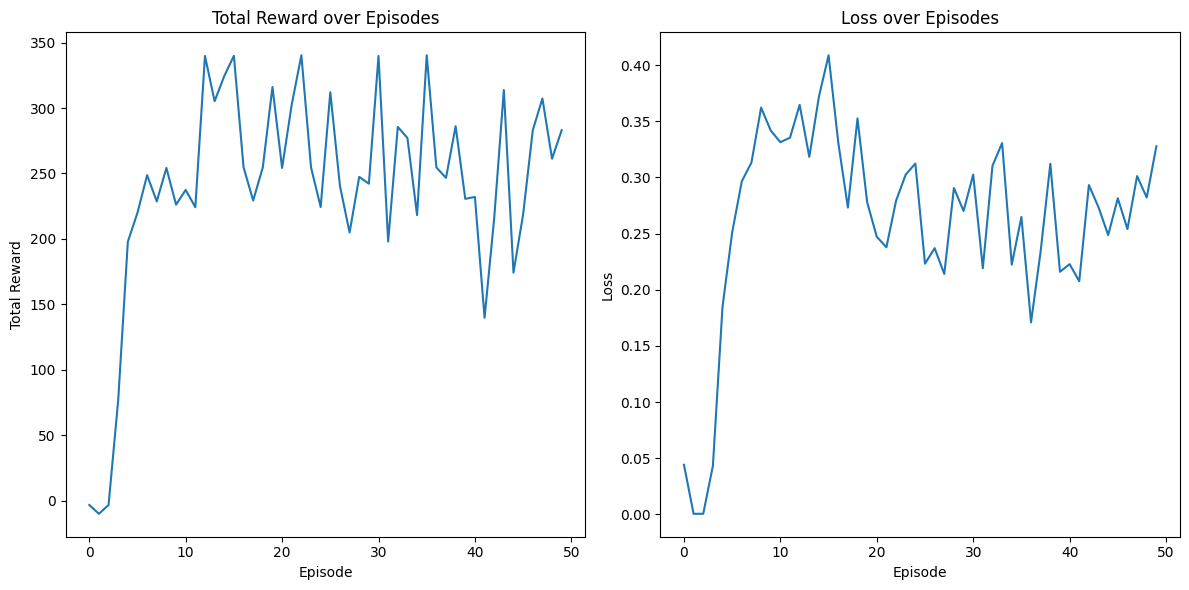

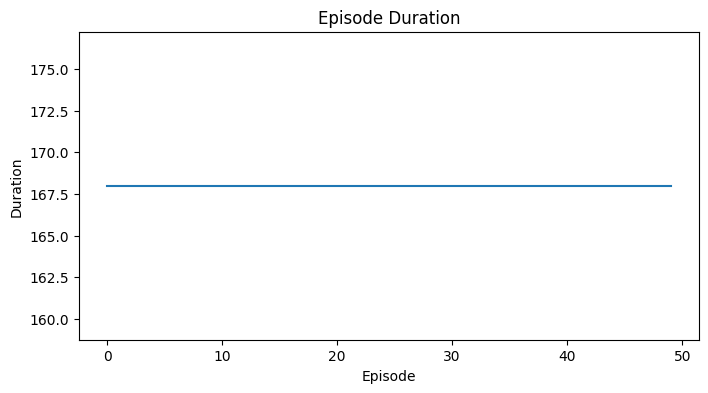

In [89]:
# Training loop

import matplotlib.pyplot as plt

episode_rewards = []
episode_losses = []
episodes_duration = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    done = False
    total_reward = 0
    steps = 0
    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor([next_state], device=device, dtype=torch.float32)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        memory.push(state, action, next_state, reward)
        state = next_state
        total_reward += reward.item()
        loss = optimize_model()
        steps += 1

    # Check if loss is not None before accessing 'item'
    if loss is not None:
        episode_losses.append(loss.item())

    episode_rewards.append(total_reward)
    episodes_duration.append(steps)

    print(f"Episode {episode}, Total Reward: {total_reward}, Loss: {loss}")

    if episode % update_every == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plot total rewards and losses
plt.figure(figsize=(12, 6))

# Plot the total rewards
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward over Episodes')

# Plot the losses
plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')

plt.tight_layout()
plt.show()

# Plot the duration of each episode
plt.figure(figsize=(8, 4))
plt.plot(episodes_duration)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Episode Duration')
plt.show()

# do not print warnings
import warnings
warnings.filterwarnings('ignore')
